## Importing necessary libraries

In [ ]:
from google.colab import drive
from google.colab.patches import cv2_imshow
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import cv2
import tensorflow as tf
import torchvision.transforms as transforms
from PIL import Image
from skimage import exposure
from tqdm import tqdm

from skimage import exposure, filters, util
from scipy.ndimage import gaussian_filter
from skimage.restoration import denoise_bilateral
from skimage.filters import unsharp_mask
from skimage.exposure import rescale_intensity
from skimage.util.dtype import img_as_ubyte

## Getting the dataset from Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_root = '/content/drive/MyDrive/pgc'
dataset_source = '/content/drive/MyDrive/pgc/koa_dataset_with_severity_grading'
dataset_destination = '/content/drive/MyDrive/pgc/preprocessed_dataset'
dataset_5_classes = '/content/drive/MyDrive/pgc/preprocessed_dataset_5_classes'
dataset_2_classes = '/content/drive/MyDrive/pgc/preprocessed_dataset_2_classes'

## Checking the dataset properties

In [ ]:
def calculate_class_frequencies(dataset_label, classes_to_exclude=[], dataset_path=dataset_5_classes):
    class_frequencies = {}
    total = 0
    for kl_grade in range(5):
        if kl_grade in classes_to_exclude:
            continue
        folder_path = f"{dataset_path}/{dataset_label}/{kl_grade}"
        count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        total += count
        class_frequencies[kl_grade] = count

    print(f"Total of images={total}")
    return class_frequencies

Total of images=6844
Total of images=908
Total of images=1129
Total of images=905
{'train': (2708, 1238, 1798, 897, 203), 'test': (351, 162, 244, 122, 29), 'val': (448, 208, 292, 146, 35), 'calib': (350, 162, 244, 121, 28)}


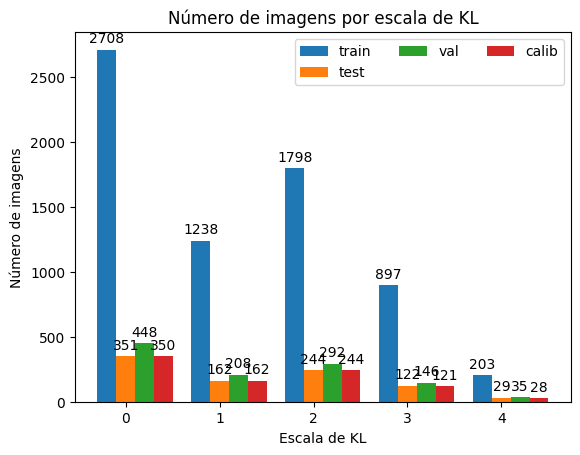

In [ ]:
kl_grades = ("0", "1", "2", "3", "4")
# kl_grades = ("0", "2", "3", "4")
# kl_grades = ("2", "3", "4")
# kl_grades = ("0", "1")

classes_to_exclude = []

class_frequencies = {
    "train": calculate_class_frequencies("train", classes_to_exclude),
    "test": calculate_class_frequencies("test", classes_to_exclude),
    "val": calculate_class_frequencies("val", classes_to_exclude),
    "calib": calculate_class_frequencies("calib", classes_to_exclude)
}

image_count = {
    "train": tuple([v for k,v in class_frequencies["train"].items()]),
    "test": tuple([v for k,v in class_frequencies["test"].items()]),
    "val": tuple([v for k,v in class_frequencies["val"].items()]),
    "calib": tuple([v for k,v in class_frequencies["calib"].items()])
}

print(image_count)

x = np.arange(len(kl_grades))
width = 0.20
multiplier = 0

fig, ax = plt.subplots()

for dataset, count in image_count.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, count, width, label=dataset)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Número de imagens')
ax.set_xlabel('Escala de KL')
ax.set_title('Número de imagens por escala de KL')
ax.set_xticks(x + width, kl_grades)
ax.legend(loc='upper right', ncols=3)
plt.show()

In [ ]:
folder_path = f"{dataset_source}/train/4_augmented"
count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
print(count)

4671


### Balance the dataset using data augmentation

In [ ]:
def augment_class_folder(input_folder, output_folder, current_count, num_augmented_images=500, seed=42):
    random.seed(seed)
    np.random.seed(seed)

    os.makedirs(output_folder, exist_ok=True)

    image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
    total_original_images = len(image_files)

    images_to_select = min(total_original_images, 100)  # Select at most 100 images to ensure variety
    augmentations_per_image = int(np.ceil(num_augmented_images / images_to_select))

    selected_images = random.sample(image_files, images_to_select)

    print(f"Selected {images_to_select} images for augmentation")
    print(f"Will generate ~{augmentations_per_image} versions per selected image")

    # Define augmentation transforms
    augmentation_transforms = [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    ]

    augmented_count = 0
    pbar = tqdm(total=num_augmented_images, desc="Generating augmented images")

    # Process each selected image
    while augmented_count < num_augmented_images:
        for img_file in selected_images:
            if augmented_count >= num_augmented_images:
                break

            input_path = os.path.join(input_folder, img_file)
            img = Image.open(input_path).convert('RGB')

            # Apply random combinations of transforms
            augmented_img = img.copy()

            # Randomly select 2-3 transforms
            num_transforms = random.randint(2, 3)
            selected_transforms = random.sample(augmentation_transforms, num_transforms)

            for transform in selected_transforms:
                augmented_img = transform(augmented_img)

            # Save augmented image
            base_name = os.path.splitext(img_file)[0]
            output_path = os.path.join(
                output_folder,
                f"{base_name}_aug.png"
            )
            augmented_img.save(output_path, 'png', quality=100)

            augmented_count += 1
            pbar.update(1)

            if augmented_count >= num_augmented_images:
                break

    pbar.close()
    return augmented_count

In [ ]:
def augment_dataset(dataset_root, classes_to_augment, num_augmentations):
    results = {}
    print(f"Augmenting {num_augmentations} images per class...")

    for class_num in classes_to_augment:
        class_folder = os.path.join(dataset_root, 'train', f"{class_num}")
        output_folder = os.path.join(dataset_root, 'train', f"{class_num}")

        if not os.path.exists(class_folder):
            print(f"Warning: Folder for KL{class_num} not found at {class_folder}")
            continue

        print(f"\nAugmenting KL{class_num} class...")
        class_counts = calculate_class_frequencies("train")
        current_count = class_counts[class_num]
        augmented_count = augment_class_folder(
            class_folder,
            output_folder,
            current_count,
            num_augmentations)

        results[class_num] = {
            "current_count": current_count,
            "augmented_count": augmented_count,
            "total_count": current_count + augmented_count
        }

    print("\nAugmentation Results:")
    print("-" * 50)
    for class_name, counts in results.items():
        print(f"\n{class_name}:")
        print(f"  Original images: {counts['current_count']}")
        print(f"  Augmented images: {counts['augmented_count']}")
        print(f"  Total images: {counts['total_count']}")

In [ ]:
augment_dataset(dataset_source, classes_to_augment=[1, 3, 4], num_augmentations=500)

In [ ]:
def delete_augmented_images(dataset_root, classes_to_delete):
    for class_num in classes_to_delete:
        class_folder = os.path.join(dataset_root, 'train', f"{class_num}")
        image_files = [f for f in os.listdir(class_folder) if "_aug_" in f]
        for image_file in image_files:
            image_path = os.path.join(class_folder, image_file)
            os.remove(image_path)

In [ ]:
delete_augmented_images(dataset_source, classes_to_delete=[1, 3, 4])

## Testing preprocessing techniques


In [ ]:
def equalize_image(image):
    # convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # apply histogram equalization
    equalized_image = cv2.equalizeHist(gray_image)

    return equalized_image

In [ ]:
def preprocess_image(image):
    # convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(2, 2))

    equalized = clahe.apply(gray_image)

    return equalized

In [ ]:
def print_image_histogram(image):
    hist, bins = np.histogram(image.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()

    plt.plot(cdf_normalized, color='b')
    plt.hist(image.flatten(), 256, [0, 256], color='r')
    plt.xlim([0, 256])
    plt.legend(('cdf', 'histograma'), loc='upper left')
    plt.ylabel('Número de pixels')
    plt.xlabel('Intensidade de pixel')
    plt.show()

In [ ]:
image = cv2.imread('/content/9001695L.png')

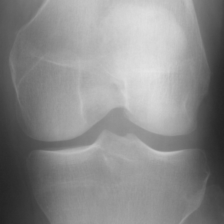

In [ ]:
cv2_imshow(image)
# print_image_histogram(image)

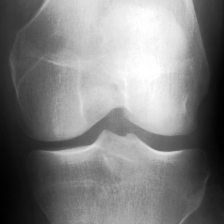

In [ ]:
equalized_image = equalize_image(image)
# print_image_histogram(equalized_image)
cv2_imshow(equalized_image)

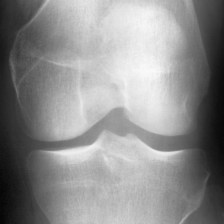

In [ ]:
processed_image = preprocess_image(image)
cv2_imshow(processed_image)

## Preprocessing x-ray images

In [ ]:
def preprocess_dataset(dataset_label, src_path, dst_path):
    for kl_grade in range(5):
        src_folder = f"{src_path}/{dataset_label}/{kl_grade}"
        dest_folder = f"{dst_path}/{dataset_label}/{kl_grade}"
        os.makedirs(dest_folder, exist_ok=True)

        image_files = [f for f in os.listdir(src_folder) if f.endswith((".png", ".jpg", ".jpeg"))]

        for filename in tqdm(image_files, desc=f"Processing KL grade {kl_grade} - {dataset_label}"):
            image_path = os.path.join(src_folder, filename)
            image = cv2.imread(image_path)
            preprocessed_image = preprocess_image(image)
            cv2.imwrite(os.path.join(dest_folder, filename), preprocessed_image)

In [ ]:
for dataset_label in ["train", "test", "val"]:
    preprocess_dataset(dataset_label, dataset_source, dataset_destination)

Processing KL grade 4 - val: 100%|██████████| 27/27 [00:00<00:00, 47.19it/s]


In [ ]:
def check_filenames(dataset_label, src_path, dst_path):
    for kl_grade in range(5):
        src_folder = f"{src_path}/{dataset_label}/{kl_grade}"
        dest_folder = f"{dst_path}/{dataset_label}/{kl_grade}"
        os.makedirs(dest_folder, exist_ok=True)

        src_files = [f for f in os.listdir(src_folder) if f.endswith((".png", ".jpg", ".jpeg"))]
        dest_files = [f for f in os.listdir(dest_folder) if f.endswith((".png", ".jpg", ".jpeg"))]

        for filename in src_files:
            if filename not in dest_files:
                print(f"Arquivo {filename} não encontrado em {dest_folder}")

In [ ]:
for dataset_label in ["train", "test", "val"]:
    check_filenames(dataset_label, dataset_source, dataset_destination)

## Duplicate dataset excluding classes

In [ ]:
def copy_dataset(classes_to_exclude, dataset_name, new_dataset_name, dataset_label):
  for kl_grade in range(5):
    if kl_grade in classes_to_exclude:
      continue

    src_folder = f"{dataset_root}/{dataset_name}/{dataset_label}/{kl_grade}"
    dest_folder = f"{dataset_root}/{new_dataset_name}/{dataset_label}/{kl_grade}"
    os.makedirs(dest_folder, exist_ok=True)

    image_files = [f for f in os.listdir(src_folder) if f.endswith((".png", ".jpg", ".jpeg"))]

    for filename in tqdm(image_files, desc=f"Copying KL grade {kl_grade} - {new_dataset_name}"):
        src_path = os.path.join(src_folder, filename)
        dest_path = os.path.join(dest_folder, filename)
        img = cv2.imread(src_path)
        cv2.imwrite(dest_path, img)

In [ ]:
for dataset_label in ["train", "test", "val"]:
  copy_dataset(classes_to_exclude=[0,1], dataset_name="preprocessed_dataset_0", new_dataset_name="preprocessed_dataset_3_classes", dataset_label=dataset_label)

Copying KL grade 2 - preprocessed_dataset_3_classes: 100%|██████████| 1798/1798 [01:24<00:00, 21.23it/s]
Copying KL grade 3 - preprocessed_dataset_3_classes: 100%|██████████| 897/897 [00:40<00:00, 22.16it/s]
Copying KL grade 4 - preprocessed_dataset_3_classes: 100%|██████████| 203/203 [00:08<00:00, 23.61it/s]
Copying KL grade 2 - preprocessed_dataset_3_classes: 100%|██████████| 488/488 [00:21<00:00, 22.33it/s]
Copying KL grade 3 - preprocessed_dataset_3_classes: 100%|██████████| 243/243 [00:10<00:00, 24.14it/s]
Copying KL grade 4 - preprocessed_dataset_3_classes: 100%|██████████| 57/57 [00:42<00:00,  1.34it/s]
Copying KL grade 2 - preprocessed_dataset_3_classes: 100%|██████████| 292/292 [00:12<00:00, 23.86it/s]
Copying KL grade 3 - preprocessed_dataset_3_classes: 100%|██████████| 146/146 [00:06<00:00, 22.57it/s]
Copying KL grade 4 - preprocessed_dataset_3_classes: 100%|██████████| 35/35 [00:24<00:00,  1.43it/s]


In [ ]:
def create_2_classes_dataset(dataset_name, new_dataset_name, dataset_label):
  for kl_grade in range(5):
    new_kl_grade = 0 if kl_grade <= 1 else 1

    src_folder = f"{dataset_root}/{dataset_name}/{dataset_label}/{kl_grade}"
    dest_folder = f"{dataset_root}/{new_dataset_name}/{dataset_label}/{new_kl_grade}"
    os.makedirs(dest_folder, exist_ok=True)

    image_files = [f for f in os.listdir(src_folder) if f.endswith((".png", ".jpg", ".jpeg"))]

    for filename in tqdm(image_files, desc=f"Copying KL grade {kl_grade} - {new_dataset_name}"):
        src_path = os.path.join(src_folder, filename)
        dest_path = os.path.join(dest_folder, filename)
        img = cv2.imread(src_path)
        cv2.imwrite(dest_path, img)

In [ ]:
for dataset_label in ["train", "test", "val"]:
  create_2_classes_dataset(dataset_name="preprocessed_dataset_0", new_dataset_name="preprocessed_dataset_2_classes", dataset_label=dataset_label)

Copying KL grade 0 - preprocessed_dataset_2_classes: 100%|██████████| 2708/2708 [02:26<00:00, 18.50it/s]
Copying KL grade 1 - preprocessed_dataset_2_classes: 100%|██████████| 1238/1238 [01:00<00:00, 20.32it/s]
Copying KL grade 2 - preprocessed_dataset_2_classes: 100%|██████████| 1798/1798 [01:38<00:00, 18.29it/s]
Copying KL grade 3 - preprocessed_dataset_2_classes: 100%|██████████| 897/897 [00:42<00:00, 20.87it/s]
Copying KL grade 4 - preprocessed_dataset_2_classes: 100%|██████████| 203/203 [00:09<00:00, 20.84it/s]
Copying KL grade 0 - preprocessed_dataset_2_classes: 100%|██████████| 701/701 [00:30<00:00, 22.68it/s]
Copying KL grade 1 - preprocessed_dataset_2_classes: 100%|██████████| 324/324 [00:15<00:00, 21.55it/s]
Copying KL grade 2 - preprocessed_dataset_2_classes: 100%|██████████| 488/488 [00:21<00:00, 22.29it/s]
Copying KL grade 3 - preprocessed_dataset_2_classes: 100%|██████████| 243/243 [00:16<00:00, 14.32it/s]
Copying KL grade 4 - preprocessed_dataset_2_classes: 100%|█████████

# Create a calibration set

In [ ]:
def create_calibration_set(dataset_name, dataset_label, classes_to_exclude=[]):
  for kl_grade in range(5):
    if kl_grade in classes_to_exclude:
      continue

    src_folder = f"{dataset_root}/{dataset_name}/{dataset_label}/{kl_grade}"
    dest_folder = f"{dataset_root}/{dataset_name}/calib/{kl_grade}"
    os.makedirs(dest_folder, exist_ok=True)

    image_files = [f for f in os.listdir(src_folder) if f.endswith((".png", ".jpg", ".jpeg"))]
    calib_set_size = int(len(image_files) * 0.5)
    calib_images = random.sample(image_files, calib_set_size)

    for filename in tqdm(calib_images, desc=f"Copying KL grade {kl_grade} - calib"):
        src_path = os.path.join(src_folder, filename)
        dest_path = os.path.join(dest_folder, filename)
        img = cv2.imread(src_path)
        cv2.imwrite(dest_path, img)

        # Remove the image from the original folder
        os.remove(src_path)

In [ ]:
create_calibration_set(dataset_name="preprocessed_dataset", dataset_label="test", classes_to_exclude=[])

Copying KL grade 4 - calib: 100%|██████████| 13/13 [00:00<00:00, 19.76it/s]
